### Import Library

In [168]:
# !pip install opencv-python
# !pip install tensorflow # 2 or above
# !pip install keras

In [169]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from scipy import signal

# 4.1 VGG16 Model Parameters

In [170]:
#Read image fil
src1 = cv2.imread("./img1.jpg")
src1 = cv2.resize(src1,(224,224))
img1 = cv2.cvtColor(src1,cv2.COLOR_BGR2RGB)

In [171]:
# Load VGG16 model from tensorflow.keras
model = VGG16()
# model detail
print(model.summary()) # print summary

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [172]:
# retrieve kernel weights from the 1st Convolutional layer
kernels, biases = model.layers[1].get_weights()
# View CNN layer 1 architecture
model.layers[1].get_config() # print detail

{'name': 'block1_conv1',
 'trainable': True,
 'dtype': 'float32',
 'filters': 64,
 'kernel_size': (3, 3),
 'strides': (1, 1),
 'padding': 'same',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [173]:
# Preprocess Image using keras and numpy
# convert the image to an array
img = img1
img = img_to_array(img)

# expand dimensions so that it represents a single 'sample'
# -> reshape 3D(H, W, Ch) image to 4D image (sample, H, W, Ch)
img = expand_dims(img, axis = 0)

# prepare the image (e.g. scale pixel values for the vgg)
img_ready = preprocess_input(img) # NEED!!! RGB to BGR for predict

In [174]:
# Extract Model CNN Layer 1 (Get only CNN Layer 1)
model = Model(inputs = model.inputs, outputs = model.layers[1].output)
model.summary() # print Model summary

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [175]:
# Extract Results from CNN Layer 1 called feature map (shape = (sample = 1, 224, 224, n_filters))
# CNN Layer 1 -> n_filters = 64
feature_maps = model.predict(img_ready)  # shape (1, 224, 224, 64) 4D Images (set of many Images but has "only first set" feature_maps[0])

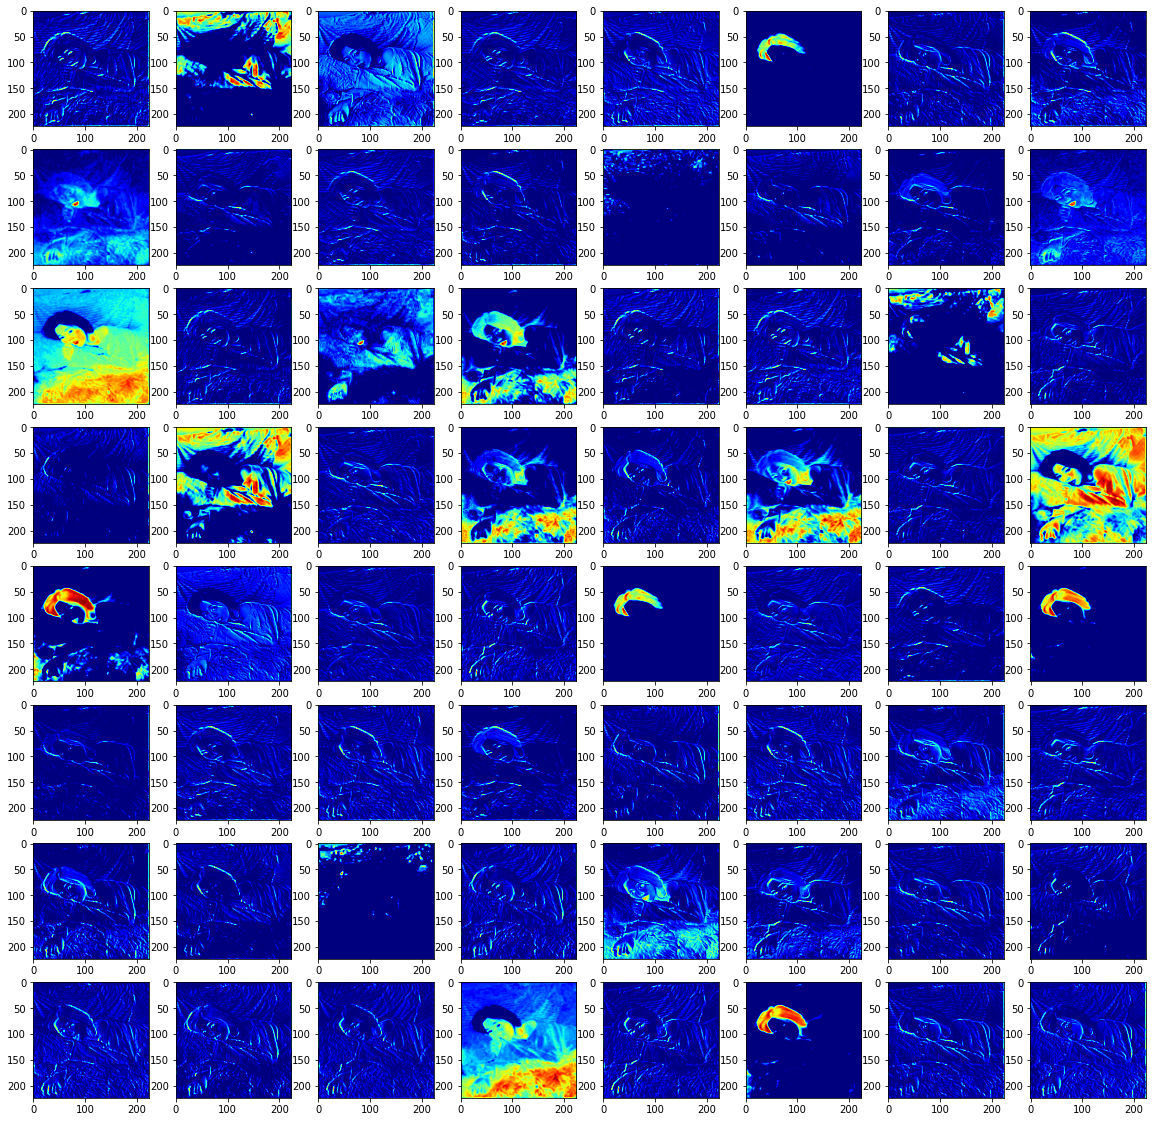

In [176]:
# Display images of feature_maps
# Do Subplot() 8x8
index = 0
f, ax = plt.subplots(8, 8, figsize = (20,20))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(feature_maps[0, :, :, index], cmap='jet') # 1-8
        index+=1
plt.show()

# 4.2 Image Preparation (From Scratch)

In [177]:
img = cv2.imread('./img1.jpg')
img = cv2.resize(img,(224,224))
img = img.astype('float')

In [178]:
# Image subtract dataset mean of R, G, B
# img_mean_RGB = [123.68, 116.779, 103.939] # RGB-> meanR, meanG, meanB
img_mean_BGR = [103.939, 116.779, 123.68] # BGR-> meanB, meanG, meanR

# Subtracting mean
for i in range(3):
    img[:, :, i] -= img_mean_BGR[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


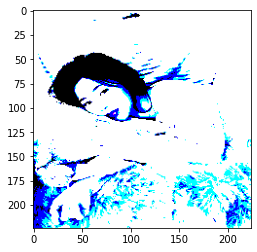

In [179]:
# Image reshape from 3D image (H, W, Ch) -> 4D image (1, H, W, Ch)
img = img.reshape((1,224,224,3)) # only 224 (mimic model)
imgBGR = img
plt.imshow(imgBGR[0])
plt.show()

# 4.3 Cov2D

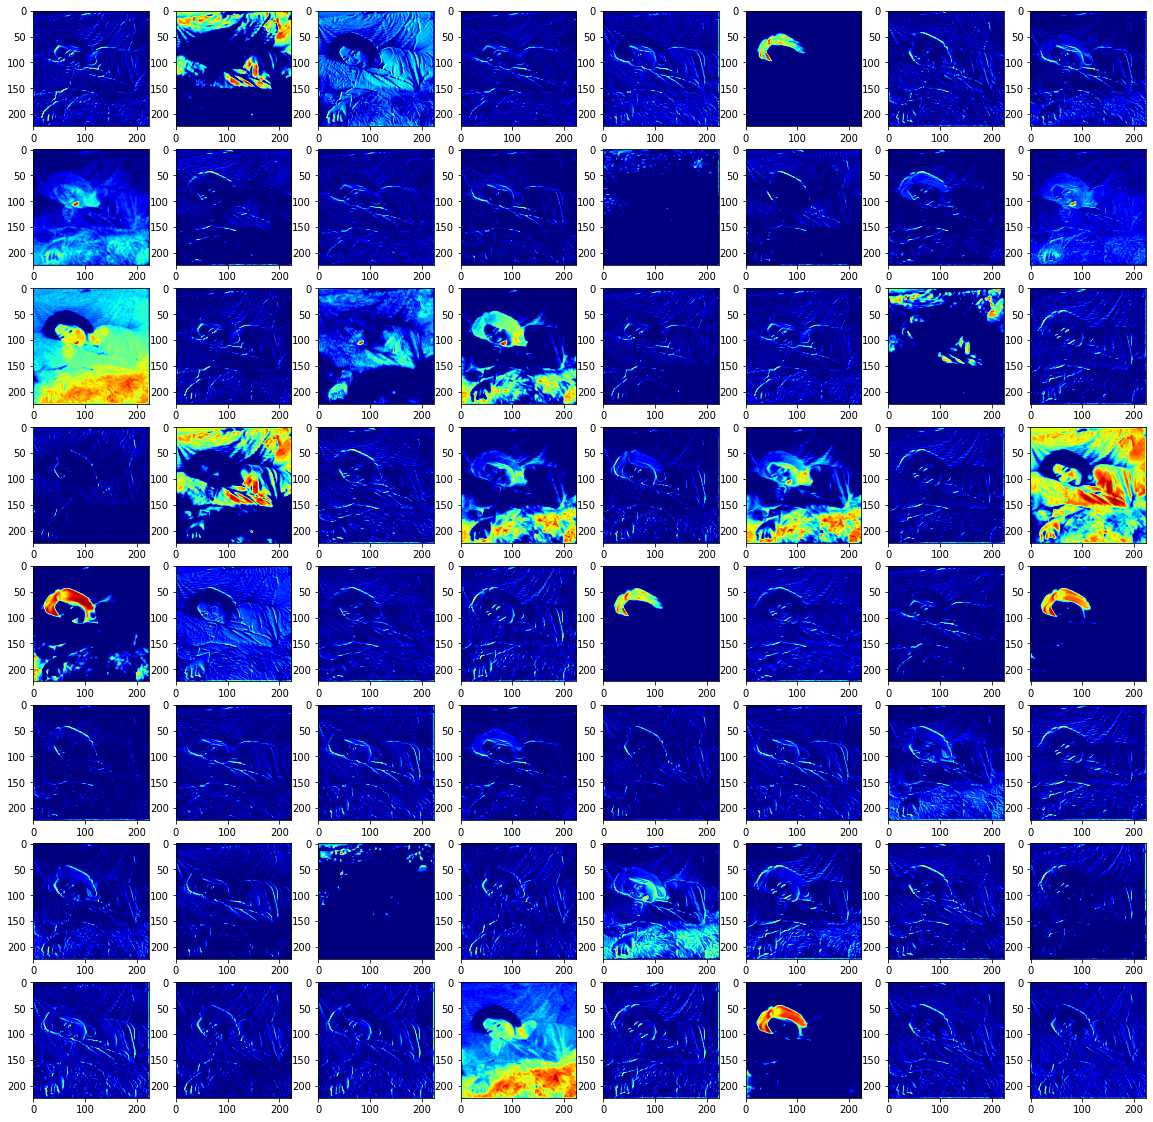

In [180]:
# operate 2D convolution to image from 4.2 (imgBGR)
# image convolution with kernel each color channel (every color channel)
index = 0
f, ax = plt.subplots(8, 8, figsize = (20,20))
for i in range(8):
    for j in range(8):
        B = signal.convolve2d(imgBGR[0, :, :, 0], kernels[:, :, 0, index], mode='same', boundary='fill', fillvalue=0)  
        G = signal.convolve2d(imgBGR[0, :, :, 1], kernels[:, :, 1, index], mode='same', boundary='fill', fillvalue=0) 
        R = signal.convolve2d(imgBGR[0, :, :, 2], kernels[:, :, 2, index], mode='same', boundary='fill', fillvalue=0) 
        image_sum = B + G + R
        # if < 0 cast to 0 
        image_sum = np.maximum(image_sum, 0)    # np.maximum(n1, n2) -> max of every node array
        ax[i, j].imshow(image_sum, cmap='jet')
        index+=1
plt.show()
# -> zero padding